In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Summary

    * As in KMeans, we have 2 clusters from MeanShift while also being able to detect possible outliers.
    
    * The MeanShift results are controlled by the bandwidth parameter, in turn determined by the quantile argument.
    
    * The charge and type predictors of the data not used in the learning process.
    
    * Scaler for data used is MinMaxScaler.

In [2]:
import numpy as np
import pandas as pd

In [13]:
from silhouette_plot import silhouette_plot
from plot_func import plot_func
from barplot_func_v2 import decode_fn_v2, uniforming_func, barplot_func_v2
from common_feature import common_feature, categories_dict

In [4]:
import jupyterthemes as jt
jt.jtplot.style(theme = 'grade3', context = 'paper', ticks=True, grid = False)

### Importing Data

In [5]:
scaled_data = np.load('scaled_traindata.npz', allow_pickle=True, mmap_mode='r')

In [6]:
scaled_data.files

['scaled_data', 'arr_names']

In [7]:
scaled_data.get('arr_names')

array(['pt1', 'eta1', 'phi1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1',
       'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'sigmaEtaEta2',
       'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2', 'x0_-1', 'x0_1',
       'x0_EB', 'x0_EE'], dtype=object)

In [8]:
train_data = scaled_data.get('scaled_data')
train_data

array([[0.0553233 , 0.93651436, 0.8267333 , ..., 1.        , 1.        ,
        0.        ],
       [0.04970189, 0.33448867, 0.24761253, ..., 0.        , 1.        ,
        0.        ],
       [0.00426031, 0.36142722, 0.76042529, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.07373313, 0.67250111, 0.2175304 , ..., 0.        , 0.        ,
        1.        ],
       [0.07313911, 0.43377043, 0.02285605, ..., 0.        , 1.        ,
        0.        ],
       [0.06105568, 0.82186664, 0.31306106, ..., 1.        , 0.        ,
        1.        ]])

In [9]:
train_data.shape

(10000, 24)

### Mean Shift Clustering

    Training without using the charge and type categorical predictors

In [10]:
from sklearn.cluster import MeanShift

##### Without setting bandwidth

In [11]:
mshift = MeanShift(cluster_all=False, n_jobs=3)

In [12]:
mshift_nocat = mshift.fit(train_data[:,:16])

In [14]:
mshift_nocat.get_params()

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': False,
 'min_bin_freq': 1,
 'n_jobs': 3,
 'seeds': None}

In [15]:
mshift_nocat.cluster_centers_.shape

(8, 16)

In [16]:
np.unique(mshift_nocat.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [17]:
predicted_nocat = mshift_nocat.predict(train_data[:,:16])

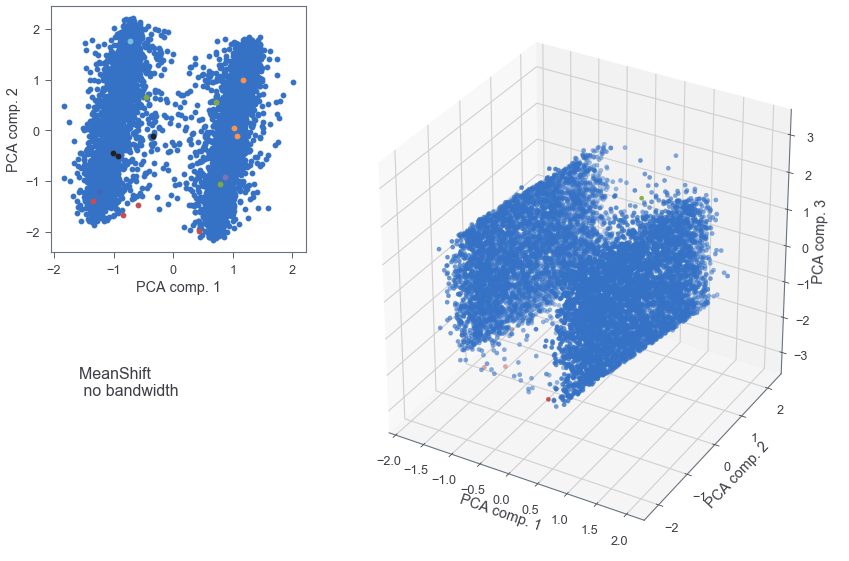

In [18]:
plot_func(data = train_data[:,:16], predicted_values=predicted_nocat, figsize=(12,8), text = 'MeanShift \n no bandwidth')

    * Terrible job

##### Estimating bandwidth

In [19]:
from sklearn.cluster import estimate_bandwidth

In [20]:
bw = estimate_bandwidth(train_data[:,:16], quantile=0.5, n_jobs=3)
bw

0.8255155951758072

In [21]:
mshift = MeanShift(bandwidth=bw, cluster_all=True, n_jobs=3)

In [22]:
mshift_nocat = mshift.fit_predict(train_data[:,:16])

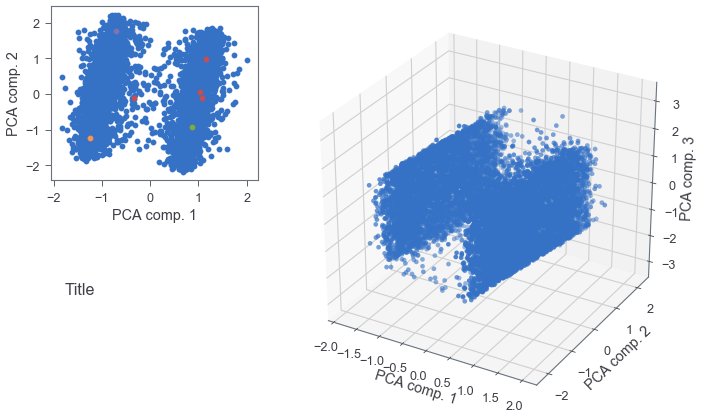

In [23]:
plot_func(train_data[:,:16], mshift_nocat)

In [24]:
# Counts of each cluster
np.unique(mshift_nocat, return_counts=True)

(array([0, 1, 2, 3, 4]), array([9993,    1,    4,    1,    1]))

    * Clearly this bandwidth estimate does not work

##### Bandwidth estimates by tuning quantiles

In [25]:
bw_list = []

[bw_list.append(estimate_bandwidth(train_data[:,:16], quantile = i, n_jobs=3)) for i in np.arange(0.1, 1, 0.2)]

bw_list 

[0.4470467299883227,
 0.6646202680420004,
 0.8255155951758072,
 0.9332573645275243,
 1.082935596514403]

In [26]:
# removing the earlier tested bandwidth
bw_list.pop(2), bw_list

(0.8255155951758072,
 [0.4470467299883227,
  0.6646202680420004,
  0.9332573645275243,
  1.082935596514403])

##### bw from quantile = 0.1

In [27]:
bw_list[0]

0.4470467299883227

In [28]:
mshift_nocat_bw1 =  MeanShift(bandwidth=bw_list[0], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw1, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([4719, 4772,   17,    2,    6,    4,   10,    1,    1,   10,    6,
           1,   57,    1,    2,    4,    3,    1,   79,   49,   44,   15,
           1,    1,  147,    2,    4,   11,    3,    4,    1,   22]))

    * Took about ~ 5 min to run
    
    * 32 clusters but only 2 are real while all others seem as outliers
    
    * Could be possibly used for outlier/anomaly detection

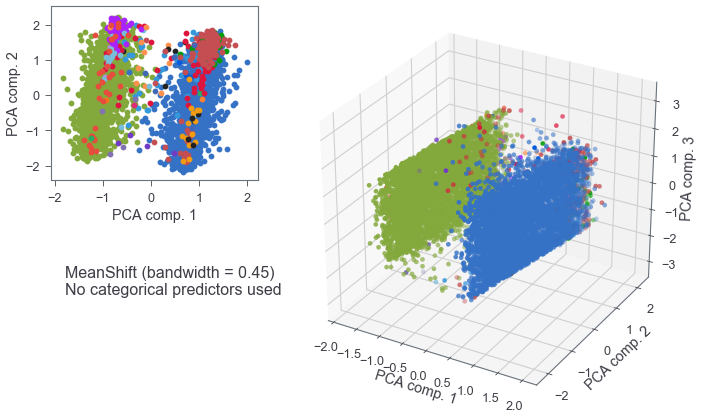

In [47]:
plot_func(train_data[:,:16],mshift_nocat_bw1, text = 'MeanShift (bandwidth = 0.45)\nNo categorical predictors used' )

##### Silhouette Analysis

In [30]:
# Calculating the score using only the main clusters
mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)]

array([1, 0, 0, ..., 0, 0, 0])

In [32]:
from sklearn.metrics import silhouette_score

In [33]:
silhouette_score(train_data[:,:16][(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
                 mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)])

0.3509882828989272

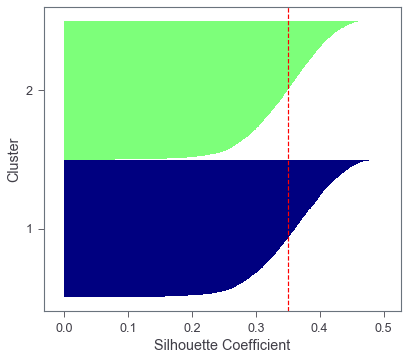

In [34]:
silhouette_plot(train_data[:,:16][(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
                mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)])

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
onehot_charge = OneHotEncoder(categories='auto', sparse=False)
enc_charge = onehot_charge.fit(np.array([[-1], [1]]))

onehot_type = OneHotEncoder()
enc_type = onehot_type.fit(np.array([['EE'], ['EB']]))

In [39]:
common_feature(train_data[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
               mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 2, enc_charge, enc_type)

'No common particle charge/type combination within the clusters'

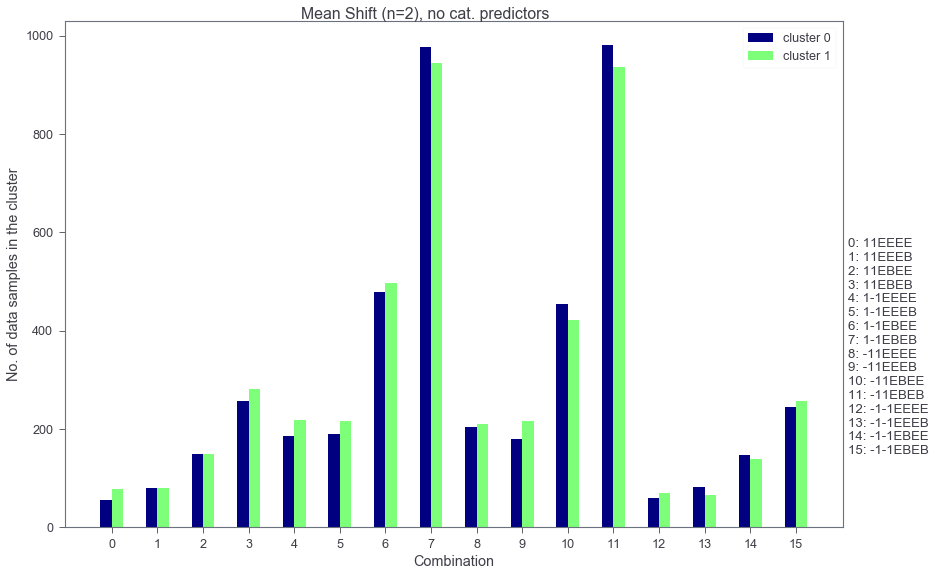

In [40]:
barplot_func_v2(train_data[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)], 
               mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)],2, enc_charge, enc_type,
               title = 'Mean Shift (n=2), no cat. predictors')

    * Similar distribution of the data points between the clusters 

##### bw from quantile = 0.3

In [41]:
bw_list[1]

0.6646202680420004

In [42]:
mshift_nocat_bw3 =  MeanShift(bandwidth=bw_list[1], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw3, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([9984,    3,    4,    1,    3,    1,    3,    1]))

    * Only 1 real cluster

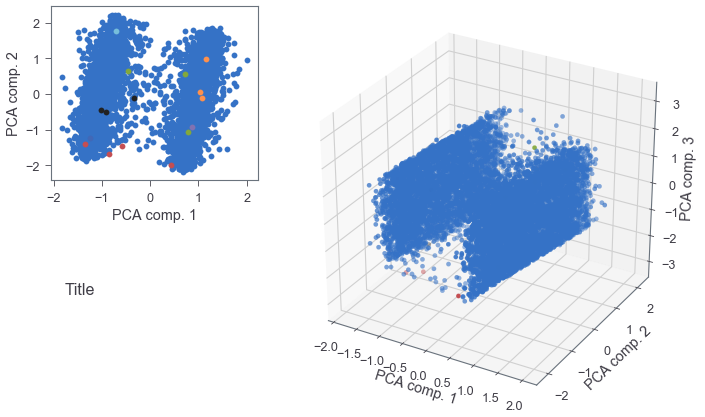

In [43]:
plot_func(train_data[:,:16], mshift_nocat_bw3)

##### bw from quantile = 0.7

In [44]:
bw_list[2]

0.9332573645275243

In [45]:
mshift_nocat_bw7 =  MeanShift(bandwidth=bw_list[2], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw7, return_counts=True)

(array([0, 1]), array([9999,    1]))

    * Similar to above

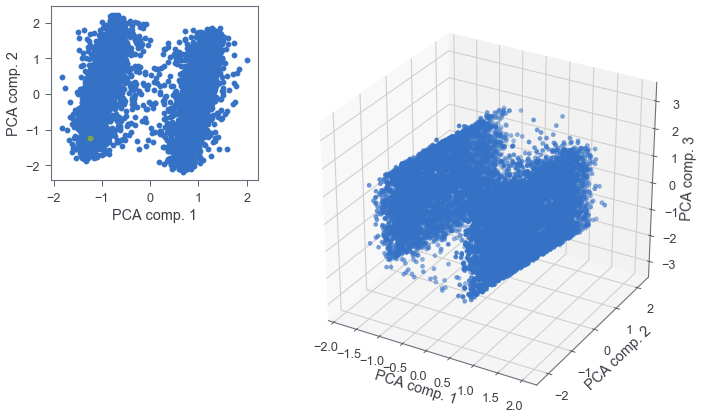

In [168]:
plot_func(train_data[:,:16], mshift_nocat_bw7)

##### bw from quantile = 0.9

In [48]:
bw_list[3]

1.082935596514403

In [49]:
mshift_nocat_bw9 =  MeanShift(bandwidth=bw_list[3], cluster_all=True, n_jobs=3).fit_predict(train_data[:,:16])
np.unique(mshift_nocat_bw9, return_counts=True)

(array([0]), array([10000]))

    * All in one cluster

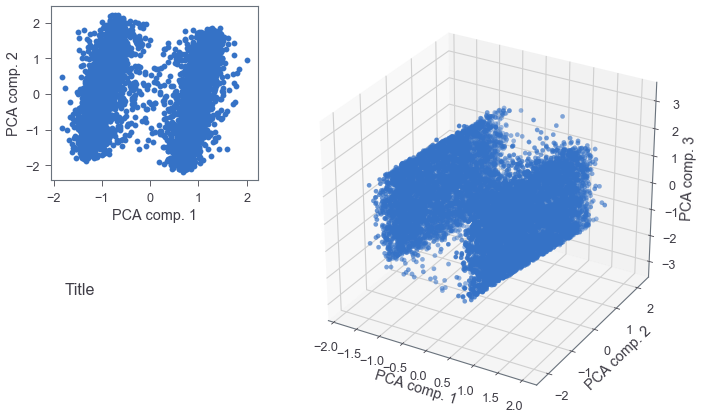

In [50]:
plot_func(train_data[:,:16], mshift_nocat_bw9)